In [91]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Importing data

In [92]:
data = pd.read_csv("../../Data/Best&Heckman/BestHeckman+SDSS+wise+LOFAR_better.csv")

# Only selecting data with a classification
data = data[data['Classification'] != 'Radio-loud AGN'] 

In [93]:
X = data.drop(columns=['Classification', 'RAJ2000', 'DEJ2000', 'SimbadName', 'E_Total_flux', 'E_Peak_flux', 'wise_ra',
       'wise_dec', 'tmass_key'])
y = data['Classification']

In [94]:
X.columns

Index(['Z_BEST', 'u_flux_corr', 'g_flux_corr', 'R_flux_corr', 'I_flux_corr',
       'z_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'J_flux_corr',
       'H_flux_corr', 'Ks_flux_corr', 'Total_flux', 'Peak_flux'],
      dtype='object')

# Dropping columns with little data (optional)

In [63]:
#X = X.drop(columns=['J_flux_corr',
#       'H_flux_corr', 'Ks_flux_corr'])

## Filter by thin redshift slice (optional)

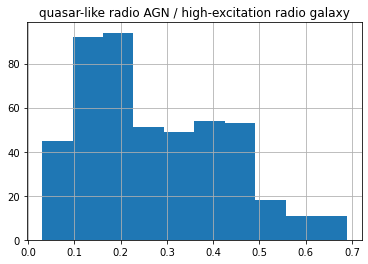

In [97]:
typ = np.unique(y)[1]
X[y==typ].Z_BEST.hist(bins=10)
plt.title(typ)
plt.show()

<AxesSubplot:>

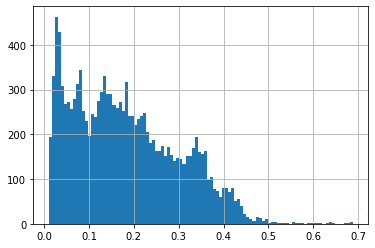

In [98]:
X.Z_BEST.hist(bins=100)

In [99]:
print(y.unique())

['jet-mode radio AGN/low-excitation radio galaxy' 'star-forming galaxy'
 'quasar-like radio AGN / high-excitation radio galaxy']


In [112]:
delta_z = 0.3

for z in np.arange(0,1,0.1):
    z = round(z,1)
    print(z, sum((X.Z_BEST >z) & (X.Z_BEST <(z+delta_z))))

0.0 10685
0.1 8612
0.2 5170
0.3 2460
0.4 558
0.5 42
0.6 15
0.7 0
0.8 0
0.9 0


In [119]:
delta_z = 0.05

print("Redshift|LERG|SFG|HERG")
for z in np.arange(0,0.2,0.01):
    z = round(z,2)
    print(z, 
          round(sum((X[y==y.unique()[0]].Z_BEST >z) & (X[y==y.unique()[0]].Z_BEST <(z+delta_z)))/sum(y==y.unique()[0]),2), 
          round(sum((X[y==y.unique()[1]].Z_BEST >z) & (X[y==y.unique()[1]].Z_BEST <(z+delta_z)))/sum(y==y.unique()[1]),2), 
          round(sum((X[y==y.unique()[2]].Z_BEST >z) & (X[y==y.unique()[2]].Z_BEST <(z+delta_z)))/sum(y==y.unique()[2]),2))

Redshift|LERG|SFG|HERG
0.0 0.03 0.58 0.02
0.01 0.04 0.66 0.03
0.02 0.06 0.63 0.06
0.03 0.08 0.49 0.07
0.04 0.11 0.36 0.08
0.05 0.12 0.28 0.09
0.06 0.13 0.21 0.09
0.07 0.14 0.17 0.11
0.08 0.15 0.13 0.11
0.09 0.16 0.1 0.12
0.1 0.17 0.09 0.13
0.11 0.18 0.08 0.15
0.12 0.19 0.07 0.15
0.13 0.19 0.05 0.17
0.14 0.19 0.04 0.17
0.15 0.18 0.03 0.17
0.16 0.18 0.03 0.15
0.17 0.18 0.02 0.15
0.18 0.17 0.02 0.14
0.19 0.16 0.01 0.13


In [113]:
z = 0
#z = 3
delta_z = 0.3

redshift_filt = (X.Z_BEST >z) & (X.Z_BEST <(z+delta_z))
X_sliced = X[redshift_filt]

# Dropping redshift column (optional)

In [102]:
#X_sliced = X_sliced.drop(columns='Z_BEST')

# Logging the data

In [22]:
# Lots of 0 values in this for some reason, so we just replace them with nans
X_sliced[X_sliced==0] = np.nan

/var/lib/condor/execute/dir_348705/ipykernel_348770/2743811275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sliced[X_sliced==0] = np.nan
/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/pandas/core/frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [23]:
X_sliced[[c for c in X_sliced.columns if c!='Z_BEST']] = np.log10(X_sliced.drop(columns='Z_BEST'))

/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## Filling nan's

In [114]:
# fill nans with 0s
#X_filled = X.fillna(0)

# FIlling with mean, filling with 0s caused a weird split into 2 groups
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#X_filled = imp_mean.fit_transform(X)

imp = IterativeImputer(max_iter=100, min_value=0)
X_filled = imp.fit_transform(X_sliced)

## Scaling

In [115]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler

scaler = StandardScaler()
X_final = scaler.fit_transform(X_filled)

## Running UMAP

In [116]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1)
embedding = reducer.fit_transform(X_final)

In [117]:
embedding.shape

(10685, 2)

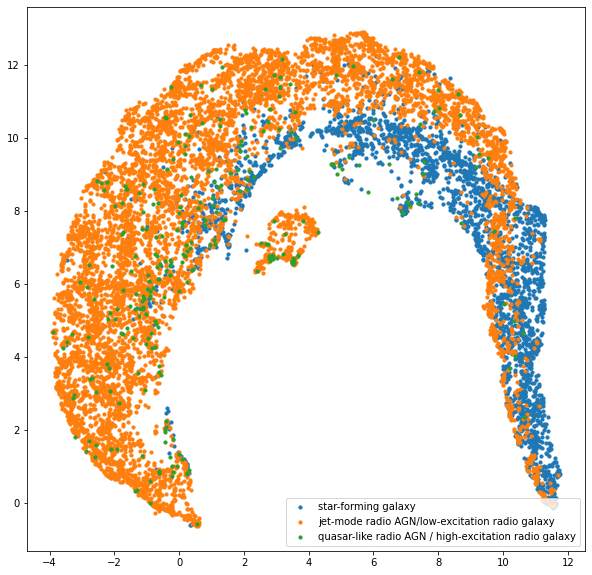

In [118]:
plt.figure(figsize=(10,10))
classes = ['star-forming galaxy',
           'jet-mode radio AGN/low-excitation radio galaxy',
           'quasar-like radio AGN / high-excitation radio galaxy',
       ]
for i in classes:
    #filt = y.loc[sample.index]['Classification']==i
    filt = y[redshift_filt]==i
    plt.scatter(embedding[:,0][filt], embedding[:,1][filt], s=10,label=i)
plt.legend()
plt.show()

In [43]:
tempdata = np.hstack((X_filled, embedding, y[redshift_filt].to_numpy()[:, np.newaxis]))
columns = list(X.columns)
columns.extend(['x', 'y', 'class'])

temp = pd.DataFrame(data=tempdata, columns=columns)
temp.to_csv('temp.csv', index=False)

## In a loop

Working on number of neighbours 5
Working on number of neighbours 6
Working on number of neighbours 7
Working on number of neighbours 8
Working on number of neighbours 9
Working on number of neighbours 10
Working on number of neighbours 11
Working on number of neighbours 12
Working on number of neighbours 13
Working on number of neighbours 14
Working on number of neighbours 15
Working on number of neighbours 16


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/lib/condor/execute/dir_2195087/ipykernel_2195177/3550598425.py", line 10, in <module>
    X_transformed = reducer.fit_transform(X_final)
  File "/Users/users/karsten/.local/lib/python3.9/site-packages/umap/umap_.py", line 2772, in fit_transform
    self.fit(X, y)
  File "/Users/users/karsten/.local/lib/python3.9/site-packages/umap/umap_.py", line 2684, in fit
    self.embedding_, aux_data = self._fit_embed_data(
  File "/Users/users/karsten/.local/lib/python3.9/site-packages/umap/umap_.py", line 2717, in _fit_embed_data
    return simplicial_set_embedding(
  File "/Users/users/karsten/.local/lib/python3.9/site-packages/umap/umap_.py", line 1156, in simplicial_set_embedding
    embedding = optimize_layout_euclidean(
  File "/Users/users/karst

TypeError: object of type 'NoneType' has no len()

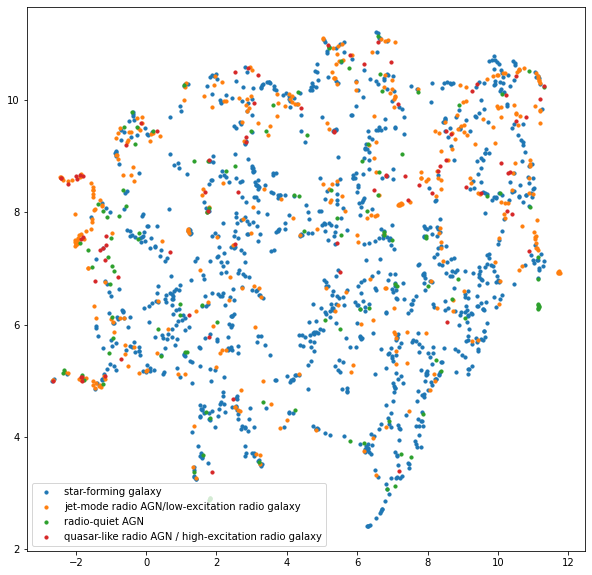

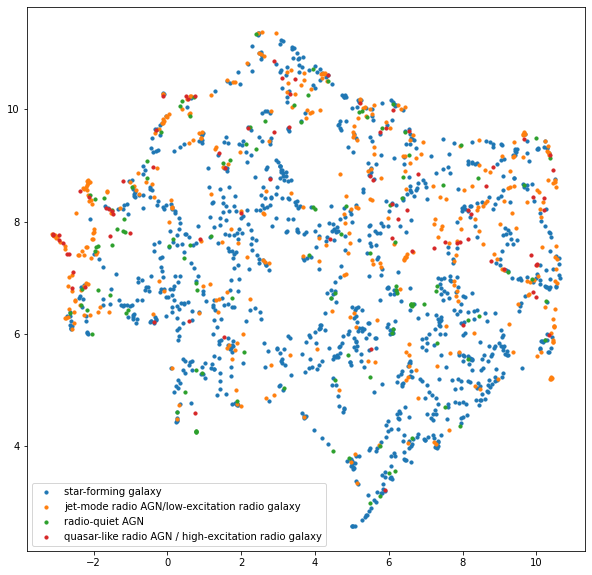

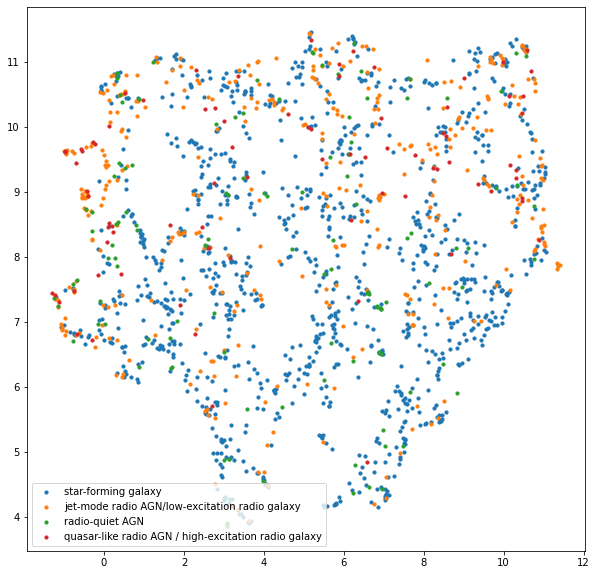

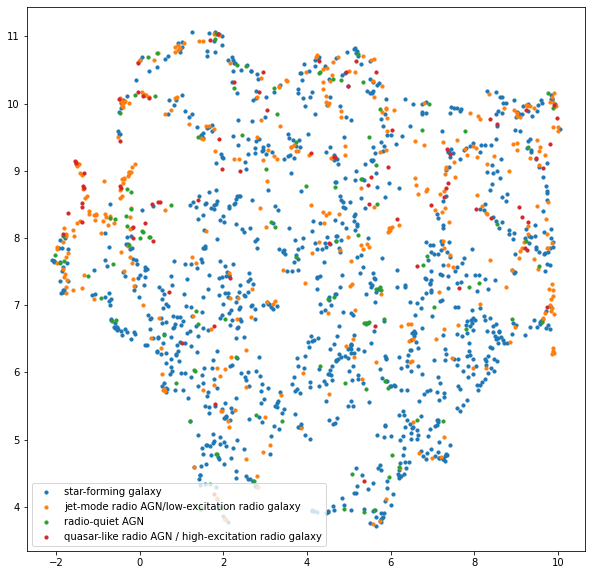

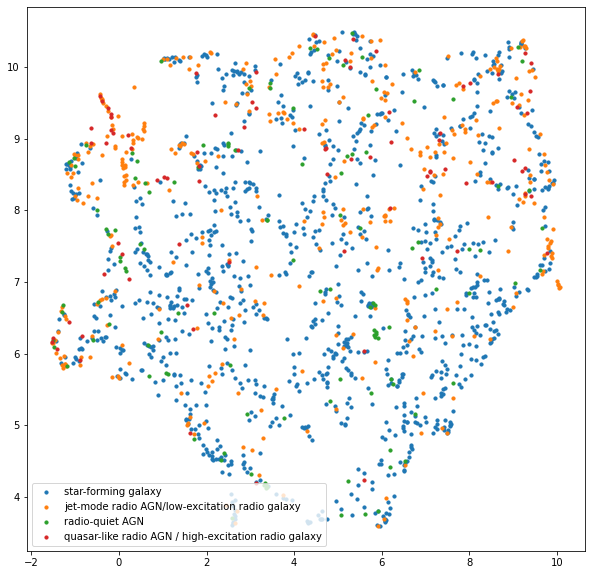

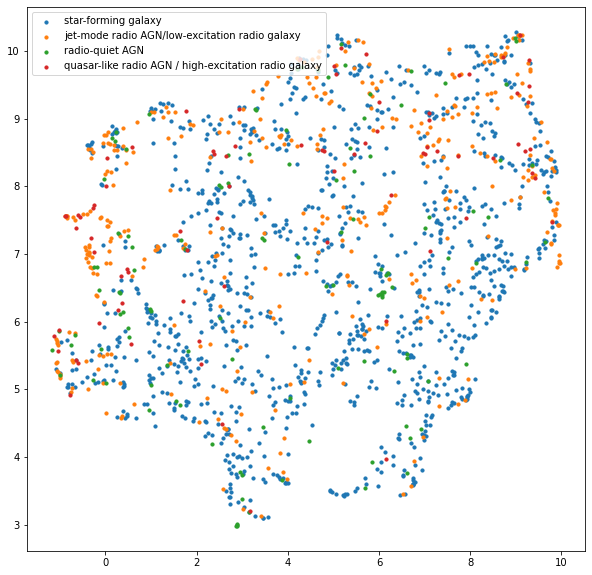

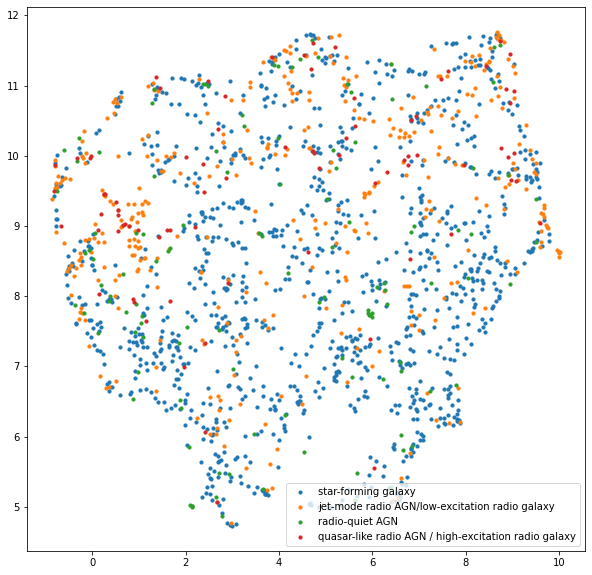

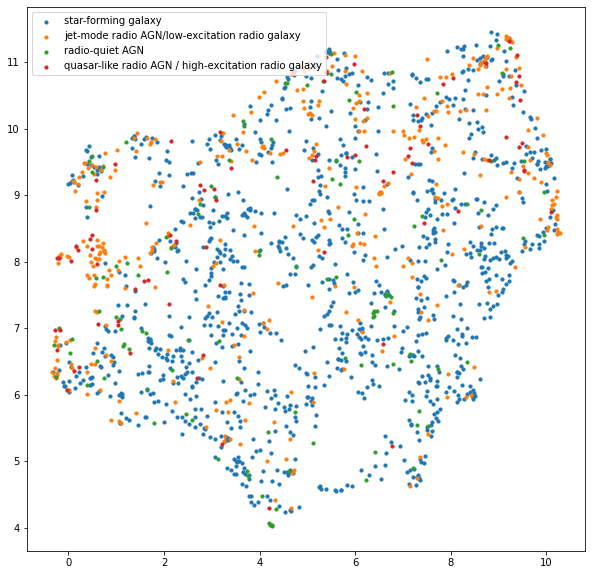

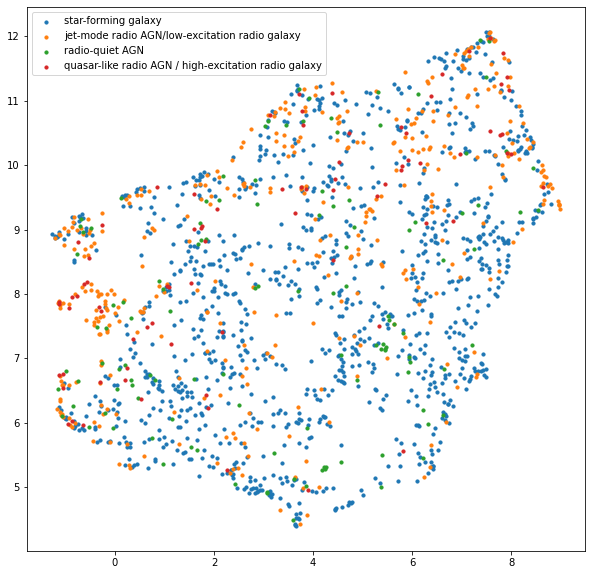

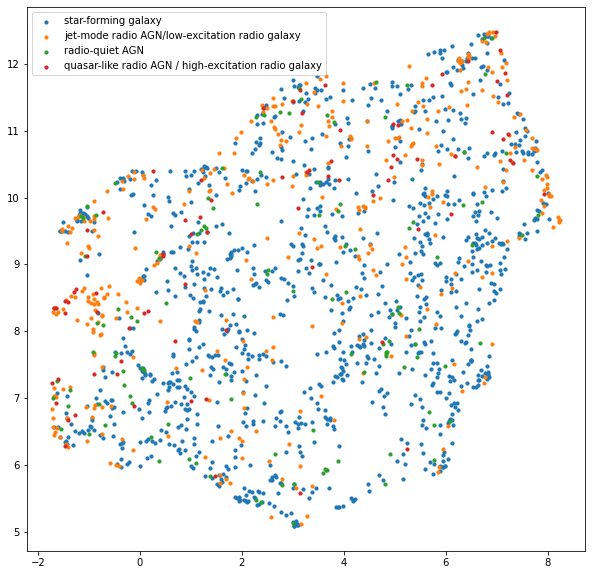

Error in callback <function flush_figures at 0x2ac246e2a1f0> (for post_execute):


KeyboardInterrupt: 

In [19]:
classes = ['star-forming galaxy',
           'jet-mode radio AGN/low-excitation radio galaxy',
           'radio-quiet AGN',
           'quasar-like radio AGN / high-excitation radio galaxy',
       ]
for i in range(5,51,1):
    print(f"Working on number of neighbours {i}")
    
    reducer = umap.UMAP(n_neighbors=i)
    X_transformed = reducer.fit_transform(X_final)

    plt.figure(figsize=(10,10))
    for name in classes:
        filt = y['Classification'][redshift_filt]==name
        plt.scatter(X_transformed[:,0][filt], X_transformed[:,1][filt], s=10, label=name)

    plt.legend()
    plt.savefig(f"./Output/UMAP/{i}.png")
    